## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from glob import glob
from tqdm.auto import tqdm
from scipy.ndimage import distance_transform_edt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

## Define the Parameters (useful for command line run using papermill)

In [3]:
CROP = 'ww'
DISTANCE = 2.5
EPSG = 25832  # Use ETRS89 / UTM Zone 32N as the projection (suitable for Germany)

# Path of the directories
WORK_DIR = '/beegfs/halder/GITHUB/RESEARCH/landscape-yield-analysis/'
os.chdir(WORK_DIR)
MAIN_DATA_DIR = '/beegfs/halder/DATA/'
WORK_DATA_DIR = os.path.join(WORK_DIR, 'data')
WORK_TEMP_DIR = os.path.join(WORK_DIR, 'temp')

OUT_DIR = os.path.join(WORK_DIR, 'output', CROP, str(DISTANCE))
if os.path.exists(OUT_DIR) == None:
    os.makedirs(OUT_DIR, exist_ok=True)
    print('Output directory successfully created!')
else:
    print('Output directory already existed.')

Output directory already existed.


## Load Hexagonal Grid for Germany


Successfully read the grids!


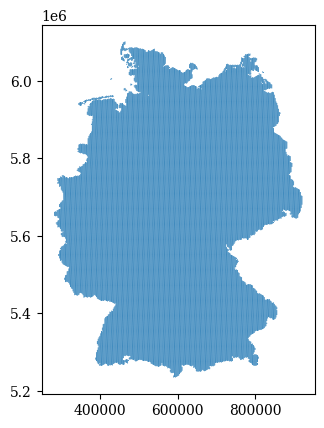

In [4]:
# Path to grid shapefile
GRID_PATH = os.path.join(WORK_DATA_DIR, 'VECTOR', f'DE_Hexbins_{DISTANCE}sqkm_EPSG_{EPSG}.shp')

# Load grid as a GeoDataFrame and retain relevant columns
grids_gdf = gpd.read_file(GRID_PATH)
grids_gdf = grids_gdf[['id', 'geometry']]
grids_gdf['id'] = grids_gdf['id'].astype(int)

print('Successfully read the grids!')
grids_gdf.plot();

## Calculate Euclidean Distance from Cropland to Other LULC Features

In [5]:
# Read the Cropland layer
lulc_path = os.path.join(MAIN_DATA_DIR, 'DE_ESA_WORLDCOVER_10M_2021_V200', 'ESA_WorldCover_2021_DE_WGS84.tif')
cropland_path = os.path.join(MAIN_DATA_DIR, 'DE_Crop_Types_2017_2021', f'{CROP}_mask_combined.tif')

# Open source raster
with rio.open(cropland_path) as src:
    cropland = src.read(1)
    cropland_profile = src.profile
    cropland_transform = src.transform
    cropland_crs = src.crs
    cropland_shape = (src.height, src.width)

with rio.open(lulc_path) as src:
    lulc = src.read(1)
    lulc_transform = src.transform
    lulc_crs = src.crs
    
    # Create an empty array for resampled data
    lulc_resampled = np.empty(cropland_shape, dtype=lulc.dtype)

    # Reproject & resample LULC to match cropland grid
    reproject(
        source=lulc,
        destination=lulc_resampled,
        src_transform=lulc_transform,
        src_crs=lulc_crs,
        dst_transform=cropland_transform,
        dst_crs=cropland_crs,
        resampling=Resampling.nearest
    )

In [6]:
# Create binary masks for the different LULC
lulc_class_code = {
    'tree_cover':10,
    'shrubland': 20,
    'grassland': 30,
    'builtup': 50,
    'bare': 60,
    'snow': 70,
    'water': 80,
    'wetland': 90,
    'mangroves': 95,
    'moss_lichen': 100
}

for _class, code in tqdm(lulc_class_code.items()):
    pixel_size = 10
    max_distance = 5000
    
    class_mask = (lulc_resampled==code)
    
    dist_raster = distance_transform_edt(~class_mask) * pixel_size
    dist_raster = np.where(dist_raster > max_distance, np.nan, dist_raster)
    print('Distance computation completed!')
    
    dist_to_cropland = np.where(cropland, dist_raster, np.nan)
    
    # Save the data
    with rio.open(os.path.join(WORK_TEMP_DIR, f'distance_to_{_class}.tif'), 'w', **cropland_profile) as dst:
        dst.write(dist_to_cropland.astype(rio.float32), 1)

  0%|          | 0/10 [00:00<?, ?it/s]

: 